In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "white")

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv("dataset/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Processing Review Texts

In [3]:
sample_review = df["review"].iloc[0]
sample_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

After taking a look at this sample review, I decided to process the review texts through several steps:
1. Remove HTML contents such as "<br \/>"
2. Remove punctuations
4. Turn all letters to lowercase
3. Remove stopwords
4. Apply Lemmatization

In [4]:
def process_review(review):
    
    # Remove HTML contents
    soup = BeautifulSoup(review, "html.parser")
    html_parsed = soup.get_text()
    
    # Remove punctuations
    punct_removed = re.sub(r"[^\w]", " ", html_parsed)
    
    # Turn all letters to lowercase
    lowercase = punct_removed.lower()
    
    # Remove stopwords
    word_lst = lowercase.split()
    stopword_removed = [word for word in word_lst if word not in set(stopwords.words("english"))]
    
    # Lemmatization
    lem = WordNetLemmatizer()
    lemmatized = [lem.lemmatize(word) for word in stopword_removed]
    res = " ".join(lemmatized)

    return res

In [5]:
process_review(sample_review)

'one reviewer mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz

In [6]:
df["review"] = df["review"].apply(process_review)

## Encode Labels

In [7]:
df["sentiment"].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [8]:
df["sentiment"].iloc[:5]

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [9]:
label_encoder = LabelEncoder()
df["sentiment"] = label_encoder.fit_transform(df["sentiment"])
df["sentiment"].iloc[:5]

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

## Train Test Split

In [10]:
reviews = np.array([review for review in df["review"]])
labels = np.array([label for label in df["sentiment"]])

In [11]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, labels, test_size = 0.2, stratify = labels)

## Tokenization

In [12]:
oov_tok = "<OOV>"
padding_type = "post"
max_length = 120
embedding_dim = 50

In [13]:
tokenizer = Tokenizer(oov_token = oov_tok)
tokenizer.fit_on_texts(train_reviews)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
train_sequences = tokenizer.texts_to_sequences(train_reviews)
train_data = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_data = pad_sequences(test_sequences, padding = padding_type, maxlen = max_length)

## LSTM Model

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer = "l2")),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(16, activation = "relu", kernel_regularizer = "l2"),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 50)           4277300   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                21248     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 4,299,605
Trainable params: 4,299,605
Non-trainable params: 0
____________________________________________

In [32]:
num_epochs = 10
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2)]
history = model.fit(train_data, train_labels, 
                    epochs = num_epochs, verbose = 2, 
                    callbacks = my_callbacks, 
                    validation_split = 0.25)

Epoch 1/10
938/938 - 103s - loss: 0.6759 - accuracy: 0.7285 - val_loss: 0.3632 - val_accuracy: 0.8641
Epoch 2/10
938/938 - 87s - loss: 0.3117 - accuracy: 0.9029 - val_loss: 0.3249 - val_accuracy: 0.8766
Epoch 3/10
938/938 - 89s - loss: 0.2192 - accuracy: 0.9432 - val_loss: 0.3420 - val_accuracy: 0.8742
Epoch 4/10
938/938 - 87s - loss: 0.1642 - accuracy: 0.9622 - val_loss: 0.3719 - val_accuracy: 0.8668


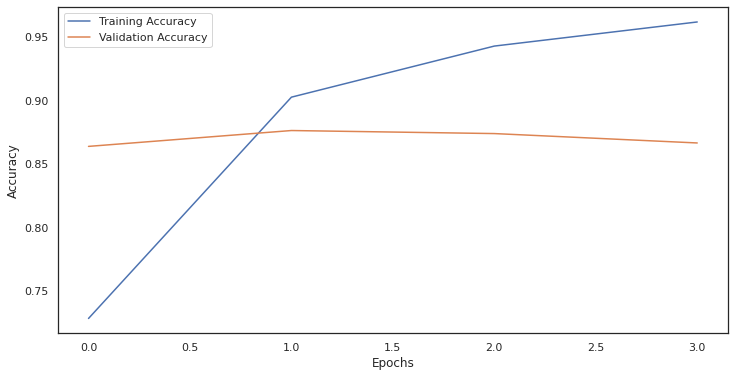

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [35]:
pred = model.predict(test_data)
accuracy = accuracy_score(test_labels, np.round(pred))
print("Test accuracy of the model is", accuracy)

Test accuracy of the model is 0.8729


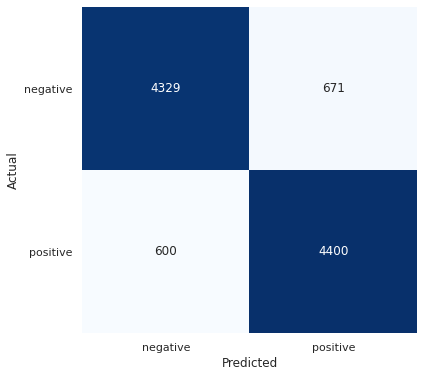

In [36]:
pred = np.round(pred)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
cm = confusion_matrix(test_labels, pred)
sns.heatmap(cm, annot = True, cbar = False, fmt='1d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(label_encoder.classes_)
ax.set_yticklabels(label_encoder.classes_, rotation=0)
plt.show()